In [ ]:
import os, sys
sys.path.append(os.path.abspath(".."))


# Premise

Machine Learning, deep learning, whatever we call it, it's a very fast, rapidly evolving field

There are countless ongoing, testing, publishing researches as of today.

A research paper usually goes somewhat like the following...

<img src="assets/Research Paper.png" alt="The WorkFlow" width="1000">

The point of this part is reading a paper, understanding it, and trying to replicate it in code

Why though? Well... a few reasons:

1. There's no point re-inventing the wheel to the solution of a problem when there are existing architectures
2. Get yourself updated to the latest technologies in the field
3. Just GIT GUD at doing machine learning! (By Practice)

I would say this goes for reinforcing your learning on other stuff as well, you start with some theory, try to put it practical use, and repeat until you are good.

<img src="assets/Again and Again.png" alt="The WorkFlow" width="500">

The paper that we will be reading is `VIT, An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale`

Yeah so Vision Transformers

# VIT Theory

Assuming that we know the basis of how attention and transformers work in theory... Let's directly move to how we do this with images instead of words

Here's a overview of the model architecture

<img src="assets/VIT.png" alt="The WorkFlow" width="1000">

## In a Nutshell:

### How the pre-processing works:

1. An image is sent in as a input
2. The image is broken down into batches
3. The batches are projected to a desirable dimension
4. Each batch concatenates (added together) their respective position embedding
5. The batches get sent to the Encoder Block

### How the Transformer Encoder works:

1. The input batches get normalized
2. Attention is calculated for every batch to every batch 
3. The attention output of each batch is concatenated (added together) with their respective un-normalized input batch (Other wise known as skip connections and residue networks)
3. The residue connections get normalized
6. The normalized residue connections goes through multiple feed forward layers (MLP stands for Multilayer Perceptron, which is just however many vanilla feed forward layers)
7. The output of the feed forward layers is concatenated (added together) with the the un-normalized residue connections

Do remind you, every batch embedding goes through the encoder separately for every step, except for computing attention, in no way are the batch embeddings concatenated together

Also, the encoder isn't just passed through once, this process can be repeated again and again

### The Additional Specifics for Classification

Similar to BERT, we add a special token at the very beginning called the  CLS token, CLS means Classification

Only the output vector from the Encoder Block for the CLS token gets sent through some extra feed forward layers to the final output layer for the purpose of multi-class classification

<img src="assets/CLS Only.png" alt="The WorkFlow" width="500">

### How Attention works for a batch, called batch 1:

(Multi-Head Attention means each batch has multiple sets of queries, keys, and values, attention is calculated independently for each set, or called head, then concatenated)

1. the initial positional embedding of every batch go through 3 separate feed forward layers, to make 3 vectors called the query, key, value
2. to calculate the attention score of batch 2 to batch 1, query 1 takes the dot product with key 2, then divided by the root of the dimension of key 2
3. this process repeats to calculate the attention score of batch 3 to batch 1, batch 4 to batch 1, batch 5 to batch 1... even batch 1 to batch 1
4. all the raw attention scores are thrown into a softmax to ensure they add up to 1
5. each normalized attention score multiplies by their respective value, and then summed up to make the final attention output of batch 1

## A More Detailed Breakdown of Image Preprocessing

### Breaking Images Down into Batches

Similar to how sentences would be divided up into individual word tokens, Images get divided up into smaller batches of fixed size

<img src="assets/Tokenization.png" alt="The WorkFlow" width="1000">

The number of patches N = HW/P^2, where H is height, W is width, P is the resolution of each patch

Oh come on, it's literally the area of a rectangle divided by the area of a square...

## Breaking Batches down into Vectors

`!!! Warning, it seems that the explanation is wrong here, don't know how to correct`

But a word embedding is a 1D vector, a batch is a 2D image, so we flatten it down to a 1D vector

What about the 3 different channels? Well, we break the 2D image into 3 channels, flatten each one into 1D, then append them together

<img src="assets/Flatten.png" alt="The WorkFlow" width="1000">



## Projection to desirable dimension

Uh yeah, it's just a feed forward layer to resize our vector to whatever dimension we like

# Setting Up

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from torchinfo import summary

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
def set_seeds(seed: int = 42):
    
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

In [6]:
import os
import zipfile
import requests
from pathlib import Path

def download_data (source: str,
                   destination: str, 
                   remove_source: bool = True) -> Path:
    
    data_path = Path("data/")
    image_path = data_path / destination

    if image_path.is_dir() == False:

        image_path.mkdir(parents=True, exist_ok=True)
        target_file = Path(source).name

        # download the zip file
        with open(data_path / target_file, "wb") as the_zip:
            request = requests.get(source)
            the_zip.write(request.content)

        # unzip the zip
        with zipfile.ZipFile(data_path / target_file, "r") as the_zip:
            the_zip.extractall(image_path)

        # Remove .zip file
        if remove_source:
            os.remove(data_path / target_file)


    # if the data is already there you don't need to do anything
    else:
        pass

    return image_path

In [7]:
download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip", destination="pizza_steak_sushi")

WindowsPath('data/pizza_steak_sushi')

In [6]:
image_size = 224

VIT_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [7]:
from pathlib import Path

# Setup path to data folder
data_path = Path("Data/pizza_steak_sushi")

# Setup Dirs
train_dir = data_path / "train"
test_dir = data_path / "test"

In [8]:
from going_modular import data_setup

batch_size = 32

# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir, test_dir=test_dir, transform=VIT_transforms, batch_size=batch_size)

# Replicating VIT

## Slicing an image down into 16 x 16 batches

The input shape of the image is: (3, 224, 224) (Color Channels, Height, Width)

The output shape of the 1D patches is (196, 768) (Number of Batches, Elements in A Batch)

If you wonder where these numbers come from... you can read the equations from the original paper:

- Number of Batches = Height * Width / Batch Height * Batch Width
- Elements in A Batch = Color Channels * Batch Height * Batch Width

A good question is how would we actually somehow iterate through the image, and break it down into 16 x 16 batches

It actually is pretty simple, just use a convolution layer with kernel size 16 x 16, stride 16

Then we can directly turn it into 1D vectors with the flatten function

(The original paper acknowledges this way of breaking images down into batches, but didn't use it)

<img src="assets/Patches.gif" alt="The WorkFlow" width="1000">

Also, apparently you can make this convolution layer learnable as well, instead of just literally doing only the job of division

Taking a random sample of an image, Convolution, then Flatten, then Permuted (for the dimension to be right)

In [20]:
# Set the patch size
patch_size = 16

conv_layer = torch.nn.Conv2d(in_channels=3, out_channels=768, kernel_size=patch_size, stride=patch_size, padding=0)
flatten = nn.Flatten(start_dim=2, end_dim=3) 

Original image shape: torch.Size([3, 224, 224]) [color channels, height, width]

Image feature map shape: torch.Size([1, 768, 14, 14]) -> [batch size, number of feature batches, feature batch height, feature batch width]

Flattened image feature map shape: torch.Size([1, 768, 196]) -> [batch size, number of feature patches, embedding resolution]

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]



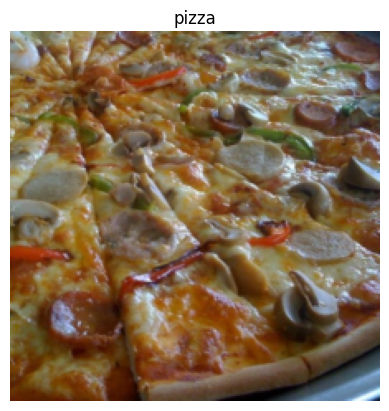

In [34]:
import random

# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
index = random.randint(0, len(image_batch))
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

# rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.imshow(image.permute(1, 2, 0)) 
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape: {image.shape} [color channels, height, width]")
print()

# Turn image into feature maps
image_out_of_conv = conv_layer(image.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape} -> [batch size, number of feature batches, feature batch height, feature batch width]")
print()

# Flatten the feature maps
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape} -> [batch size, number of feature patches, embedding resolution]")
print()

# Get flattened image patch embeddings in right shape
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch size, embedding resolution, number of feature patches]")
print()

I'm not good with matplotlib, so this is just the copied code for visualizing a part of all the embeddings, 100 of them (10 x 10 grid) before they are flattened

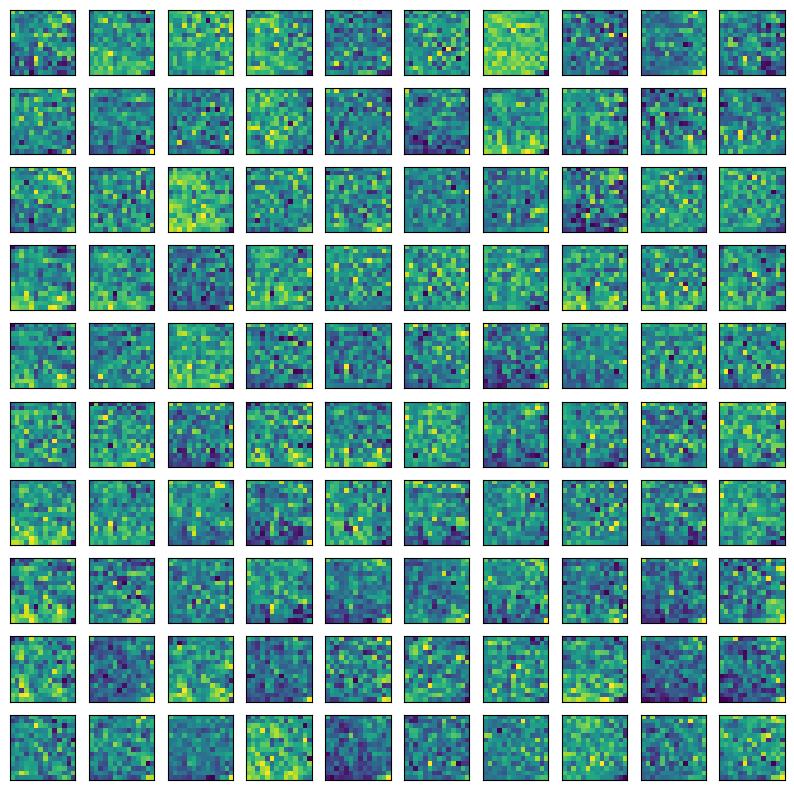

In [40]:
import matplotlib.pyplot as plt

# Assuming 'image_out_of_conv' is defined elsewhere and has shape [1, num_feature_maps, height, width]

fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(10, 10))

# Iterate over each subplot position
for row in range(10):
    for col in range(10):
        # Calculate the index of the feature map based on current row and column
        index = row * 10 + col
        
        # Extract the corresponding feature map
        # Adjust the indexing based on how your 'image_out_of_conv' is structured
        image_conv_feature_map = image_out_of_conv[:, index, :, :]
        
        # Plot the feature map on the corresponding subplot
        axs[row, col].imshow(image_conv_feature_map.squeeze().detach().numpy(), cmap='viridis')
        axs[row, col].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])  # Remove ticks and labels

### Modularizing the Patch Embedding Process

This entire process of creating the patch embedding can be turned into a single PyTorch layer.

We can do so by subclassing nn.Module and creating a small PyTorch "model" to do all of the steps above.

1. Create a class called PatchEmbedding which subclasses nn.Module (so it can be used a PyTorch layer).
2. Initialize the class with the parameters in_channels=3, patch_size=16 (for ViT-Base) and embedding_dim=768 (for ViT-Base)
3. Create a layer to turn an image into patches using nn.Conv2d() (just like above).
4. Create a layer to flatten the patch feature maps into a single dimension (just like above).
5. Define a forward() method to take an input and pass it through the layers created in 3 and 4.
6. Make sure the output shape reflects the required output shape of the ViT architecture

Crazy right? We got custom datasets, now custom layers

In [4]:
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """
     
    #yep, the class
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()

        self.patch_size = patch_size
        self.patcher = nn.Conv2d(in_channels=in_channels, out_channels=embedding_dim, kernel_size=patch_size, stride=patch_size, padding=0)
        self.flatten = nn.Flatten(start_dim=2, end_dim=3)
    

    # the forward pass
    def forward(self, image):

        # Create assertion to check that inputs are the correct shape
        image_resolution = image.shape[-1]
        assert image_resolution % self.patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"

        # Perform the forward pass
        image_patched = self.patcher(image)
        image_flattened = self.flatten(image_patched)
        return image_flattened.permute(0, 2, 1)

An example of doing the same process using custom layers

In [ ]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding()

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")

# add an extra batch dimension on the 0th index, otherwise will error
patch_embedded_image = patchify(image.unsqueeze(0)) 
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

### Classification Token Embedding

At the start of the patch embedding, a classification token is inserted alike BERT

<img src="assets/Prepend.png" alt="The WorkFlow" width="1000">

This token embedding is a learnable parameter that shares the same size as the embedding dimension (D)

In [ ]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

# The token embedding needed to be learnable
class_token = nn.Parameter(torch.rand(batch_size, 1, embedding_dimension), requires_grad=True)

# Print the class_token shape
print(f"Class token shape: {class_token.shape} -> [batch size, number of tokens, embedding dimension]")

Add it to the front of the image patch embedding tensor

In [ ]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image), dim=1) # concat on first dimension

# Print the sequence of patch embeddings with the prepended class token embedding
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch size, number of patches, embedding dimension]")

### Positional Embedding

I thought it was literally alike how positional embeddings worked for the original transformers paper, but there's a few differences

If we intuitively think about it, a sequence of text is only 1D, there's the first word, the second word... to the last word.

But for an image, it should be 2D? So each batch receives an X and Y coordinate positional embedding?

Well, the authors of the paper just tried all sorts of ways:

1. No Positional Embedding
2. 1D Positional Embedding
3. 2D Positional Embedding
4. Relative Positional Embedding (Consider Relative Distances Between Patches)

And in the end, they concluded that a 1D Positional Embedding is Enough

But, it's not the Sin and Cos Squiggles like in the original Transformers Paper, they let it be a learnable parameter

In [ ]:
# Calculate N (number of patches)
height = 224
width = 224
number_of_patches = int((height * width) / patch_size**2)

# Get embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

# Create the learnable 1D position embedding (every patch has their own positional embedding)
position_embedding = nn.Parameter(torch.rand(1, number_of_patches+1, embedding_dimension), requires_grad=True)

# Show the shape of the position embedding
print(f"Position embedding shape: {position_embedding.shape} -> [batch size, number of patches, embedding dimension]")

# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape} -> [batch size, number of patches + positional embedding, embedding dimension]")

## Multi-Headed Attention Block

### Attention

We are not explaining attention here... go read it somewhere else prior to doing this part in code

But TLDR, it's asking the question "How Important are batches to each other" here, hence attention 

### Multi-Headed

Just multiple individual instances of attention that get concatenated (appending) together

<img src="assets/Attention.png" alt="The WorkFlow" width="500">

### Layer Normalization

Layer Normalization is just Normalizing the input vector, basically rescaling the elements so they have a Gaussian Distribution wtih Mean of 0 and a Standard Deviation of 1

<img src="assets/Normalization.png" alt="The WorkFlow" width="500">

In Pytorch, they did it a little bit differently, Square Root Variance is Standard Deviation, they added a epsilon to avoid the divide by 0 problem

Also, they added 2 additional learnable parameters, they act sort of like weights and biases, and their job is to rescale the data a little better than just a Gaussian Distribution with Mean of 0 and a Standard Deviation of 1

<img src="assets/Altered assets/Normalization.png" alt="The WorkFlow" width="500">

### Coding it Out

We are going to create Custom layer that:

1. normalize outputs
2. calculates multi-head attention
3. add skip connection (We aren't adding it here yet)

In [ ]:
class MultiheadSelfAttentionBlock(nn.Module):
    """
    Creates a multi-head self-attention block ("MSA block" for short).
    """

    def __init__(self,
                 embedding_dimension:int=768,
                 num_of_heads:int=12,
                 attention_dropout:float=0):
        super().__init__()

        # Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dimension)

        # Create the Multi-Head Attention (MSA) layer
        self.multihead_attention = nn.MultiheadAttention(embed_dim=embedding_dimension,
                                                    num_heads=num_of_heads,
                                                    dropout=attention_dropout,
                                                    batch_first=True) # does our batch dimension come first?
        
    def forward(self, embeddings):

        embeddings = self.layer_norm(embeddings)

        attention_output, _ = self.multihead_attn(query=embeddings, 
                                             key=embeddings, 
                                             value=embeddings,
                                             need_weights=False) # do we also need the attention values or just the layer outputs?
        
        return attention_output
        

The query, key, and value tensors are all derived from the same input sequence, but they are not the same tensor, this code syntax can be a bit misleading

This is an example of creating an attention block, and passing through our patch + positional embeddings

In [ ]:
attention_block = MultiheadSelfAttentionBlock(embedding_dimension=768, num_of_heads=12)

patched_image_through_msa_block = attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Notice how the input and output shape of our data stays the same when it goes through the MSA block.

This doesn't mean the data doesn't change as it goes through.

## Multi-Layer-Perceptron Block

The term MLP is quite broad as it can refer to almost any combination of multiple layers (hence the "multi" in multilayer perceptron).

In the VIT paper, they used 2 feed forward layers with a GELU activation function in between

In training, we can add dropout to these layers.

So this is how it works:

1. Normalize Inputs
2. 2 feed forward layers with GELU activation function
3. add skip connection (We aren't adding it here yet)

In [ ]:
class MLPBlock(nn.Module):
    """
    Creates a layer normalized multilayer perceptron block ("MLP block" for short).
    """

    def __init__(self, 
                 embedding_dimension:int=768,
                 mlp_size:int=3072,
                 dropout:float=0.1):
        super().__init__()

        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dimension)
        
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dimension, out_features=mlp_size),
            nn.GELU(),
            nn.Linear(in_features=mlp_size, out_features=embedding_dimension),
            nn.Dropout(p=dropout)
        )

    def forward(self, input):
        return self.mlp(self.layer_norm(input))

An example of passing through the attention outputs through the MLP block.

In [ ]:
mlp_block = MLPBlock(embedding_dim=768, mlp_size=3072, dropout=0.1)

patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Again, dimension remains the same... this so later when we combine them into the encoder, we can repeatedly stack the encoder on top if itself again and again

## Combining Attention and MLP to create the Encoder

The entire encoder block is

1. Normalization
2. Attention
3. Residue Connection
4. Normalization
5. MLP
6. Residue Connection
7.Repeat

In [ ]:
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    
    def __init__(self,
                 embedding_dimension:int=768,
                 num_of_heads:int=12,
                 attention_dropout:int=0,
                 mlp_size:int=3072,
                 mlp_dropout:float=0.1):
        super().__init__()

        self.msa_block = MultiheadSelfAttentionBlock(embedding_dimension=embedding_dimension, num_of_heads=num_of_heads, attention_dropout=attention_dropout)

        self.mlp_block = MLPBlock(embedding_dimension=embedding_dimension, mlp_size=mlp_size, dropout=mlp_dropout)

    
    def forward(self, embedding):

        # The addition basically implements the residue connection
        embedding = self.msa_block(embedding) + embedding

        embedding = self.mlp_block(embedding) + embedding

        return embedding

Though here is a fun thing, Pytorch already has this entire encoder directly implemented in 1 line of code

Ah, just like how we didn't have to manually write out the multi headed attention, these encoder (and decoder) blocks are already written for us

In [ ]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, # Hidden size D from Table 1 for ViT-Base
                                                             nhead=12, # Heads from Table 1 for ViT-Base
                                                             dim_feedforward=3072, # MLP size from Table 1 for ViT-Base
                                                             dropout=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                                                             activation="gelu", # GELU non-linear activation
                                                             batch_first=True, # Do our batches come first?
                                                             norm_first=True) # Normalize first or after MSA/MLP layers?

Instead of using your own written one, there are benefits of using the PyTorch pre-built layers, such as:

- Less prone to errors (Generally, if a layer makes it into the PyTorch standard library, its been tested and tried to work.)
- Potentially better performance1 (torch.nn.TransformerEncoderLayer() can see a speedup of more than 2x on many common workloads)

Finally, since the ViT architecture uses several Transformer Layers stacked on top of each for the full architecture, you can do this with torch.nn.TransformerEncoder(encoder_layer, num_layers) where:

- Encoder Layer (The target Transformer Encoder layer created with torch.nn.TransformerEncoderLayer())
- num layer (The number of Transformer Encoder layers to stack together.)

# Combining All Parts in Code (Replicate Full Vit)

We'll focus on the ViT-Base hyperparameters from Table 1 but our code should be adaptable to other ViT variants.

In [36]:
class ViT(nn.Module):

    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""

    def __init__(self,
                image_height: int=224,
                image_width: int=224,
                color_channels: int=3,
                class_size: int=3,
                patch_size: int=16,
                transformer_layers: int=12,
                attention_heads: int=12,
                mlp_size: int=3072, 
                mlp_dropout: float=0.1,
                embedding_dropout: float=0.1,
                attention_dropout: float=0):
        super().__init__()

        # Calculate number of patches
        self.num_patches = (image_height * image_width) // (patch_size**2)

        # Calculate embedding size
        self.embedding_dimension = patch_size * patch_size * color_channels

        #Image Preprocessing
        self.classification_token_embedding = nn.Parameter(torch.rand(1, 1, self.embedding_dimension), requires_grad=True)
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, self.embedding_dimension), requires_grad=True)
        self.patch_embedding = PatchEmbedding(in_channels=color_channels, patch_size=patch_size, embedding_dim=self.embedding_dimension)

        #For Training Only
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        #Encoder Block, here is using Pytorch's already implemented code
        #The for loop in the list constructs a sequence of encoder layers equal to the specified number
        #However, nn.Sequential doesn't take in a list of values, the '*' means unpack the list of values and passing them as separate arguments sequentially to nn.Sequential
        self.encoder =  nn.Sequential(*[nn.TransformerEncoderLayer(d_model=self.embedding_dimension, 
                                                                   nhead=attention_heads, 
                                                                   dim_feedforward=mlp_size, 
                                                                   dropout=mlp_dropout, 
                                                                   activation="gelu", 
                                                                   batch_first=True, 
                                                                   norm_first=True) for _ in range(transformer_layers)])

        #Alternatively, you can use the custom class, like how we defined above

        #Classifier (It doesn't have a softmax function, as the original paper was doing multi-label classification and softmax is not suitable for that)
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=self.embedding_dimension),
            nn.Linear(in_features=self.embedding_dimension, out_features=class_size))


    def forward(self, x):

        #Get Batch Size
        batch_size = x.shape[0]

        #Create class token embedding and expand it to match the batch size
        classification_token = self.classification_token_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension

        #Create Patch Embedding
        x = self.patch_embedding(x)

        #Concatenate Class Token to front of patch embedding
        x = torch.cat((classification_token, x), dim=1)

        #Add Positional Embedding to Patch Embedding
        x = self.position_embedding + x
        
        #Apply embedding dropout
        x = self.embedding_dropout(x)

        #Pass patch, position and class embedding through transformer encoder layers
        x = self.encoder(x)

        #Put class token logit through classifier
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x

In [37]:
vision_transformer = ViT()

Let's see how it is in a Summary

In [38]:
from torchinfo import summary

# Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
summary(model=vision_transformer,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embedding)       [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                  [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                 [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)            [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (encoder)                   [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderLayer (0)       [32, 197, 768]       [32, 197, 768]       7,087,872            True
│    └─TransformerEncoderLayer (1)       [32, 197, 768]       [32, 197, 768]       7,087,872            True
│    └─Transformer

# Training

Heads up, training this architecture locally would kill my computer, and from what he showed, it's performance is not ideal at low training times

We will write the theoretical code for how to train this model, and display the loss curves that he trained

The original paper used the Adam Optimizer, Cross Entropy Loss (Actually it said nothing about loss functions in the paper)

In [ ]:
from going_modular import engine

optimizer = torch.optim.Adam(params=vision_transformer.parameters(), lr=3e-3, betas=(0.9, 0.999), weight_decay=0.3)

loss_function = torch.nn.CrossEntropyLoss()

set_seeds()

# Set the seeds
set_seeds()

# Train the model and save the training results to a dictionary
results = engine.train(model=vision_transformer,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_function,
                       epochs=10,
                       device=device)

So, here's the loss curves from his training steps, and it's all over the place

<img src="assets/Loss and Accuracy.png" alt="The WorkFlow" width="1000">

Reason Being?

- we don't have enough data
- we are not training that long like college researchers with fat ass computers

| Hyperparameter value | ViT Paper | Our implementation |
| --- | --- | --- |
| Number of training images | 1.3M (ImageNet-1k), 14M (ImageNet-21k), 303M (JFT) | 225 |
| Epochs | 7 (for largest dataset), 90, 300 (for ImageNet) | 10 |
| Batch size | 4096 | 32 |
| Learning rate warmup | 10k steps | None |
| Learning rate decay | Linear/Cosine | None |
| Gradient clipping | Global norm 1 | None |

About the "we are not training that long like college researchers with fat ass computers", in the paper they've stated

<b>Finally, the ViT-L/16 model pre-trained on the public ImageNet-21k dataset performs well on most datasets too, it could be trained using a standard cloud TPUv3 with 8 cores in approximately 30 days.<b/>

A TPUv3 costs 10 dollars per hour at the time the paper was released, rent 1 for 30 straight days would cost 7200 dollars

This cost (monetary and time) may be viable for some larger research teams or enterprises but for many people it's not.

# Transfer Learning ViT

Since our model performs terribly with this short training time, let's grab an existing pre-trained ViT model from pytorch, add an additional linear layer and see how it performs

In [7]:
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

The setting up for training...

In [4]:
from pathlib import Path

# Setup path to data folder
data_path = Path("Data/pizza_steak_sushi")

# Setup Dirs
train_dir = data_path / "train"
test_dir = data_path / "test"

In [8]:
from going_modular import data_setup

batch_size = 32
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
pretrained_vit_transforms = pretrained_vit_weights.transforms()

# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir, test_dir=test_dir, transform=pretrained_vit_transforms, batch_size=batch_size)

Adding additional linear layer at the end for our classification purposes

In [9]:
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=3).to(device)

Seeing it using torchinfo

In [10]:
from torchinfo import summary

summary(model=pretrained_vit, input_size=(32, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"], col_width=20, row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

Running Training Loop

In [11]:
from going_modular import engine

optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), lr=1e-3)

loss_function = torch.nn.CrossEntropyLoss()

set_seeds()

results = engine.train(model=pretrained_vit, train_dataloader=train_dataloader, test_dataloader=test_dataloader, optimizer=optimizer, loss_fn=loss_function, epochs=10, device=device, writer=False)

c:\Users\For My Dreams\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 10%|█         | 1/10 [00:10<01:30, 10.02s/it]

Epoch: 1 | train_loss: 0.7663 | train_acc: 0.7188 | test_loss: 0.5435 | test_acc: 0.8769


 20%|██        | 2/10 [00:19<01:18,  9.87s/it]

Epoch: 2 | train_loss: 0.3436 | train_acc: 0.9453 | test_loss: 0.3257 | test_acc: 0.8977


 30%|███       | 3/10 [00:29<01:08,  9.76s/it]

Epoch: 3 | train_loss: 0.2068 | train_acc: 0.9492 | test_loss: 0.2698 | test_acc: 0.9186


 40%|████      | 4/10 [00:39<00:58,  9.73s/it]

Epoch: 4 | train_loss: 0.1557 | train_acc: 0.9609 | test_loss: 0.2414 | test_acc: 0.9186


 50%|█████     | 5/10 [00:48<00:48,  9.69s/it]

Epoch: 5 | train_loss: 0.1244 | train_acc: 0.9727 | test_loss: 0.2271 | test_acc: 0.8977


 60%|██████    | 6/10 [00:58<00:38,  9.68s/it]

Epoch: 6 | train_loss: 0.1210 | train_acc: 0.9766 | test_loss: 0.2122 | test_acc: 0.9280


 70%|███████   | 7/10 [01:08<00:28,  9.66s/it]

Epoch: 7 | train_loss: 0.0933 | train_acc: 0.9766 | test_loss: 0.2342 | test_acc: 0.8883


 80%|████████  | 8/10 [01:17<00:19,  9.67s/it]

Epoch: 8 | train_loss: 0.0793 | train_acc: 0.9844 | test_loss: 0.2268 | test_acc: 0.9081


 90%|█████████ | 9/10 [01:27<00:09,  9.67s/it]

Epoch: 9 | train_loss: 0.1084 | train_acc: 0.9883 | test_loss: 0.2064 | test_acc: 0.9384


100%|██████████| 10/10 [01:37<00:00,  9.74s/it]

Epoch: 10 | train_loss: 0.0646 | train_acc: 0.9922 | test_loss: 0.1795 | test_acc: 0.9176


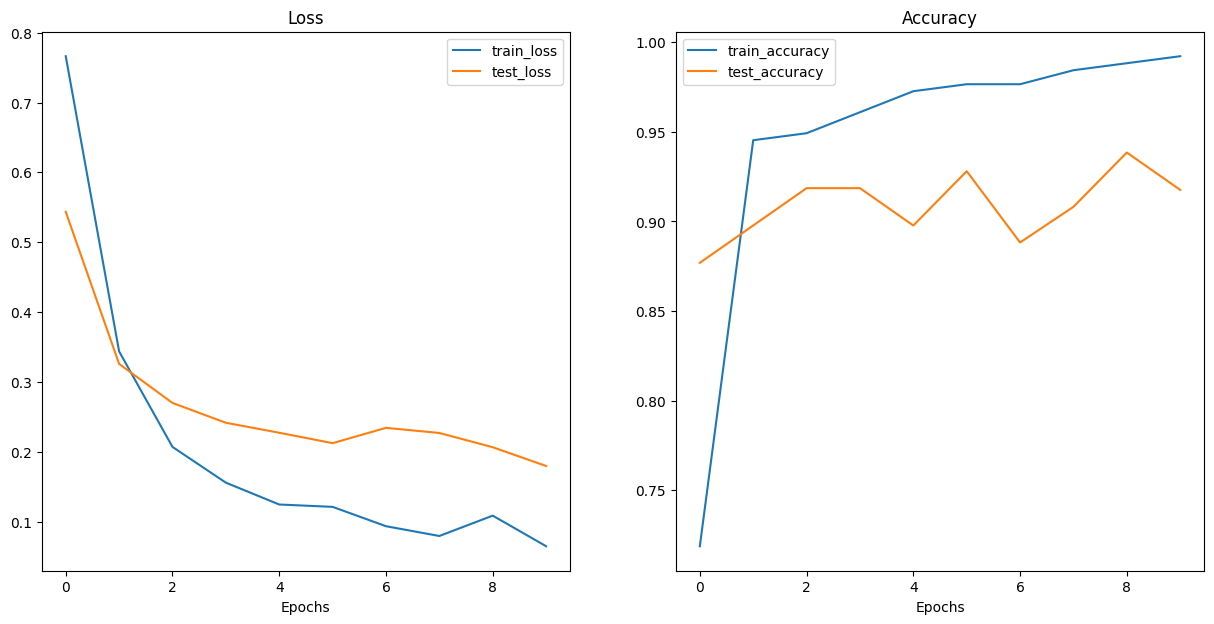

In [12]:
from going_modular import scripts.helper_functions

helper_functions.plot_loss_curves(results)

That honestly is probably the best performing model that we have so far, the amazing thing a transformer can do

# Saving the Model

In [13]:
from going_modular import utils

utils.save_model(pretrained_vit, target_dir="models", model_name="pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models\pretrained_vit_feature_extractor_pizza_steak_sushi.pth


Let's see how large this model is

In [15]:
from pathlib import Path

model_size = Path("models/pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes
print(f"Pretrained ViT feature extractor model size: {model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


In comparison to the EffnetB2...

			
| Model | Model size (MB) | Test loss | Test Accuracy |
| --- | --- | --- | --- | 
| EffNetB2 | 29 | ~0.3906 | ~0.9384 |
| ViT | 327 | ~0.1795 | ~0.9384 |

The EffNetB2 model is ~11x smaller than the ViT model with similar results for test loss and accuracy.

However, the ViT model's results may improve when trained more.

Leaking into the next section... for model deployment, we most likely have limitations on the size of the models if we want them to be able to run on less capable devices, like websites/phones

Tradeoffs, tradeoffs, they run around in circles, is the extra performance worth it for the extra size?